# DO APERTURE PHOTOMETRY FOR A SINGLE STAR

In [ ]:
## load Libraires
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.units as u
from astropy.table import Table
from scipy import interpolate
from shapely.geometry import LineString, Point
from astropy.stats import sigma_clipped_stats
import requests,io
!pip install photutils
from photutils.aperture import aperture_photometry, CircularAnnulus, CircularAperture

black


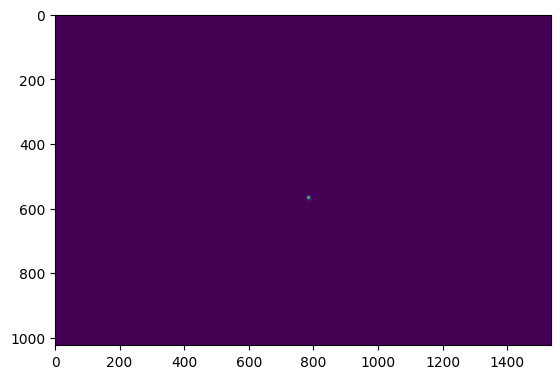

blue


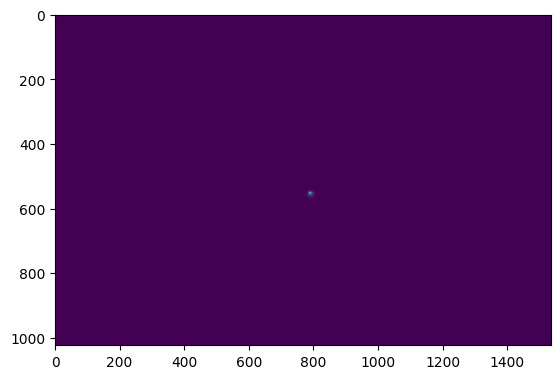

green


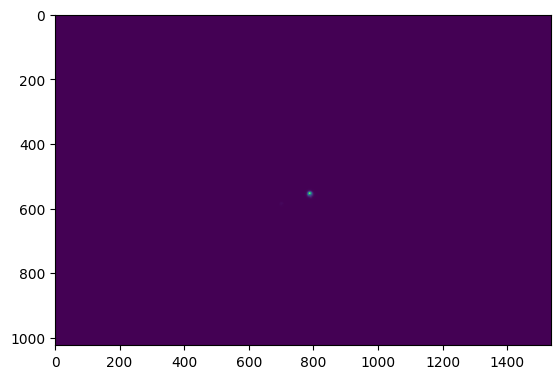

red


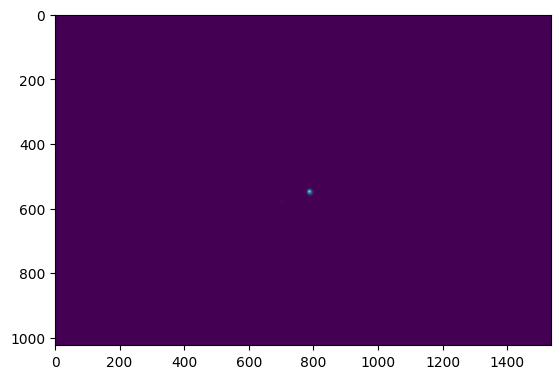

In [ ]:
# Criação de um dicionário com as funções de cada filtro
filtros={'black'
:{'fits1':[],'head':[],'image':[],'pos_guess':[],'img':[],'position':[],'phot_table':[],'y':[],'phot_table':[],
                  'threshold':[],'segment_img':[],'srcmask':[],'bkg':[],'erimage':[],'low':[],'up':[],'aperture':[],'norm':[],'flux':[],'error':[]}
,'blue'
         :{'fits1':[],'head':[],'image':[], 'pos_guess':[],'img':[],'position':[],'phot_table':[],'y':[],'phot_table':[],
                'threshold':[],'segment_img':[],'srcmask':[],'bkg':[],'erimage':[],'low':[],'up':[],'aperture':[],'norm':[],'flux':[],'error':[]}
,'green'
         :{'fits1':[],'head':[],'image':[], 'pos_guess':[],'img':[],'position':[],'phot_table':[],'y':[],'phot_table':[],
                  'threshold':[],'segment_img':[],'srcmask':[],'bkg':[],'erimage':[],'low':[],'up':[],'aperture':[],'norm':[],'flux':[],'error':[]}
,'red'
        :{'fits1':[],'head':[],'image':[], 'pos_guess':[],'img':[],'position':[],'phot_table':[],'y':[],'phot_table':[],
                'threshold':[],'segment_img':[],'srcmask':[],'bkg':[],'erimage':[],'low':[],'up':[],'aperture':[],'norm':[],'flux':[],'error':[]}
         }
## Load image
dir="/content/sample_data/"
base_filename = "sheliak_"
end_filename = "_mask_combined"
for k,v in filtros.items():
  filtros[k]['fits1'] = fits.open(dir+ f"{base_filename}{k}{end_filename}.fits")
  filtros[k]['head'] = filtros[k]['fits1'][0].header
  filtros[k]['image'] = filtros[k]['fits1'][0].data
  plt.imshow(filtros[k]['image'])
  print(k)
  plt.show()


Get noise image (background and Poisson error)

In [ ]:
## First mask sources
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from astropy.stats import SigmaClip # Added this import statement
from photutils.background import Background2D
from photutils.background import MedianBackground
from astropy.stats import SigmaClip
from photutils.utils import calc_total_error

for k,v in filtros.items():
  sigma_clip = SigmaClip(sigma=3.0)
  filtros[k]['threshold'] = detect_threshold(filtros[k]['image'], nsigma=2.0, sigma_clip=sigma_clip)
  filtros[k]['segment_img'] = detect_sources(filtros[k]['image'], filtros[k]['threshold'], npixels=10)
  footprint = circular_footprint(radius=10)

  filtros[k]['srcmask'] = filtros[k]['segment_img'].make_source_mask(footprint=footprint)
  #plt.imshow(filtros[k]['srcmask'])
  #plt.show()

  ## Get background image with sources masked

  sigma_clip = SigmaClip(sigma=3.0)
  bkg_estimator = MedianBackground()
  filtros[k]['bkg'] = Background2D(filtros[k]['image'],(50,50),filter_size=(3,3),sigma_clip=sigma_clip,  ## this is the background and its noise
                    bkg_estimator=bkg_estimator,mask=filtros[k]['srcmask'])
  filtros[k]['erimage'] = calc_total_error(filtros[k]['image'].astype(np.float64)-filtros[k]['bkg'].background, filtros[k]['bkg'].background_rms, 1.5)  ## this is the Poisson error added to background noise # Changed this line

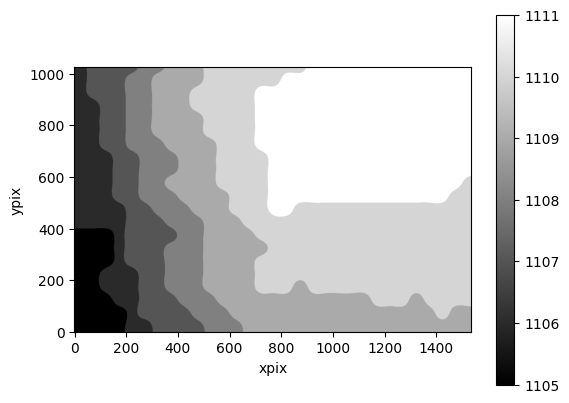

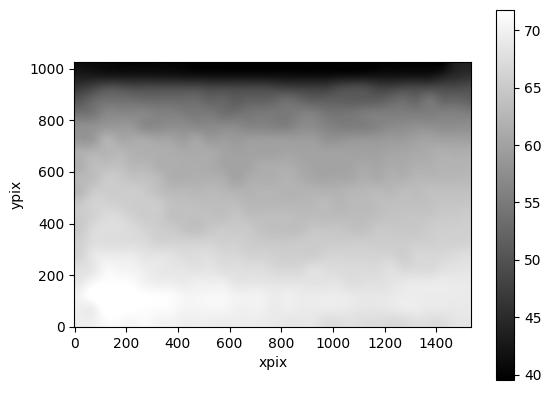

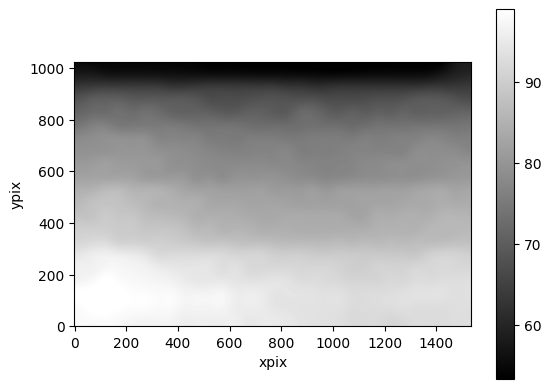

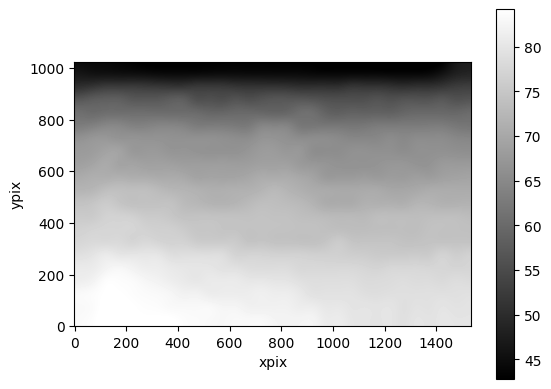

In [ ]:
## Background
for k,v in filtros.items():
  filtros[k]['lo'],filtros[k]['up'] = np.percentile(filtros[k]['bkg'].background,1),np.percentile(filtros[k]['bkg'].background,99) ## Use filtros[k]['bkg'].background to access the background data
  plt.figure()
  plt.imshow(filtros[k]['bkg'].background,cmap='gray',origin='lower',clim=(filtros[k]['lo'],filtros[k]['up']))
  plt.colorbar()
  plt.xlabel('xpix')
  plt.ylabel('ypix')
  dic={'black','blue','green','red'}


black
black


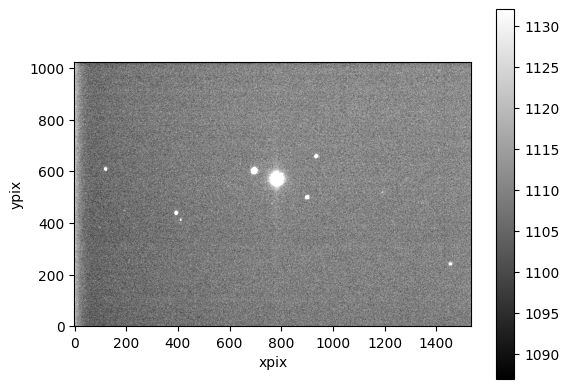

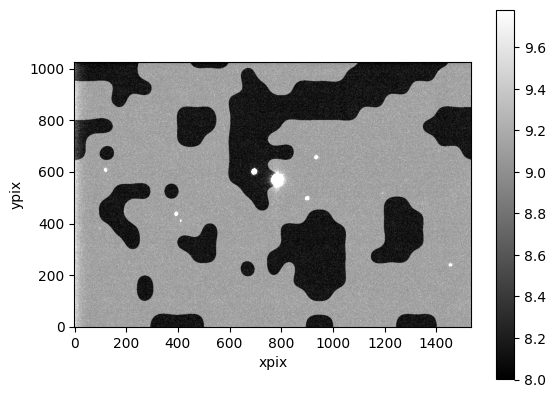

blue
blue


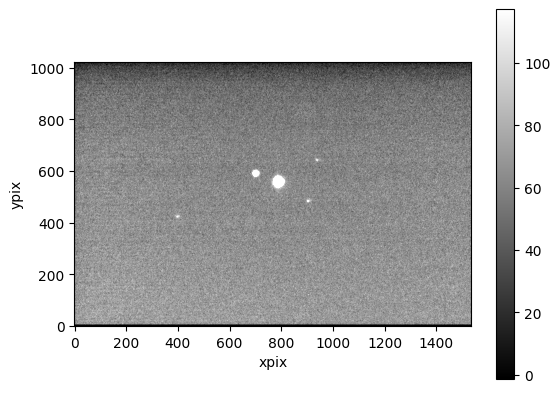

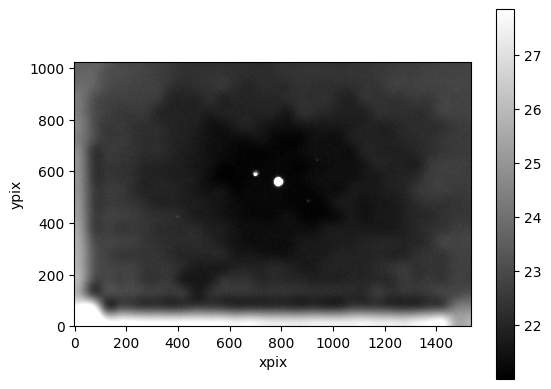

green
green


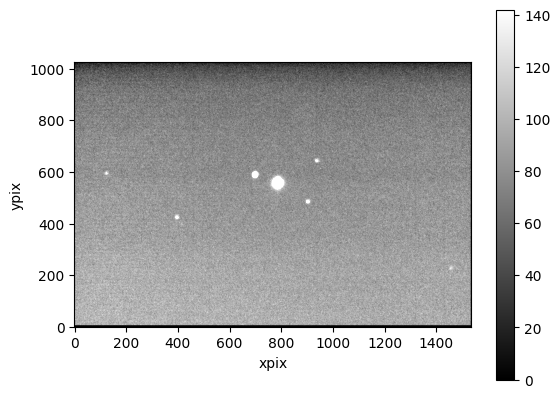

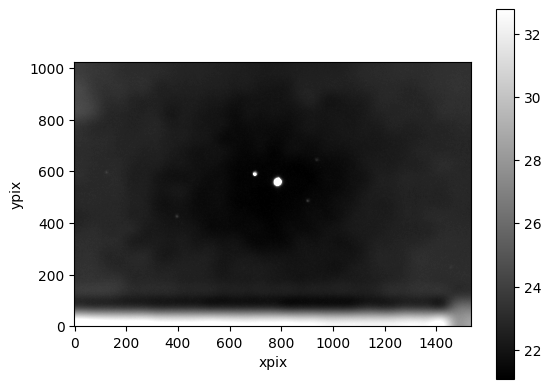

red
red


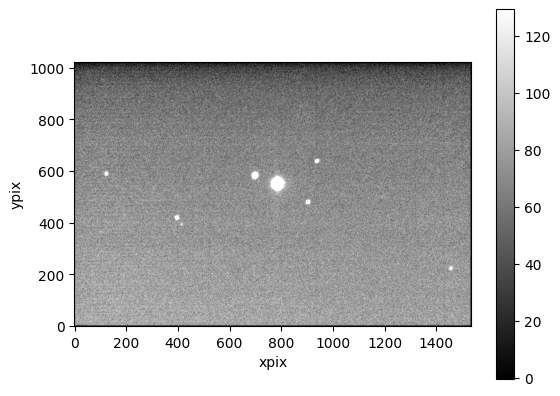

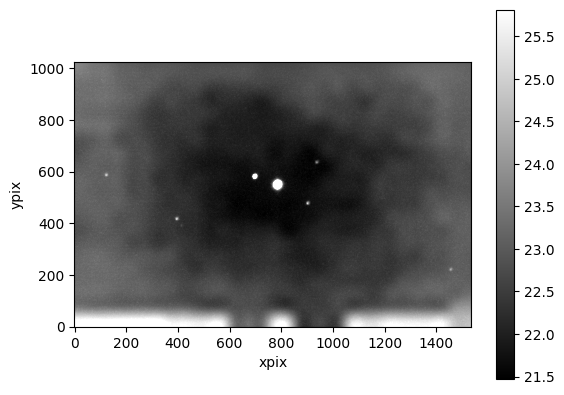

In [ ]:
## Image and noise Plot
for k,v in filtros.items():
  print(k)
  filtros[k]['lo'],filtros[k]['up'] = np.percentile(filtros[k]['image'],1),np.percentile(filtros[k]['image'],99)
  plt.figure()
  plt.imshow(filtros[k]['image'],cmap='gray',origin='lower',clim=(filtros[k]['lo'],filtros[k]['up']))
  plt.colorbar()
  plt.xlabel('xpix')
  plt.ylabel('ypix')
  print(k)
  plt.figure()
  filtros[k]['lo'],filtros[k]['up'] = np.percentile(filtros[k]['erimage'],1),np.percentile(filtros[k]['erimage'],99)
  plt.imshow(filtros[k]['erimage'],cmap='gray',origin='lower',clim=(filtros[k]['lo'],filtros[k]['up']))
  plt.colorbar()
  plt.xlabel('xpix')
  plt.ylabel('ypix')
  plt.show()

## Get central position of star with initial guess

black


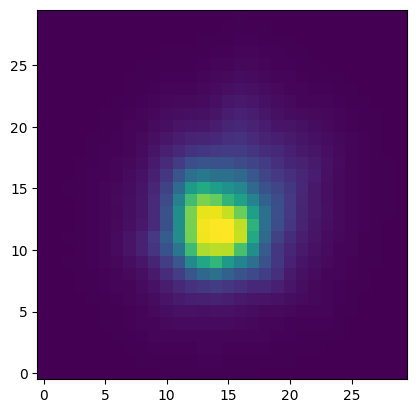

[783.58574814 567.93657006]
blue


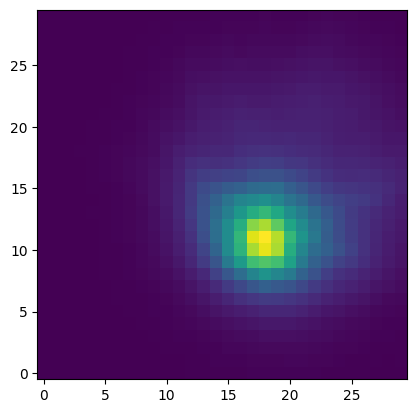

[788.65669114 554.97894743]
green


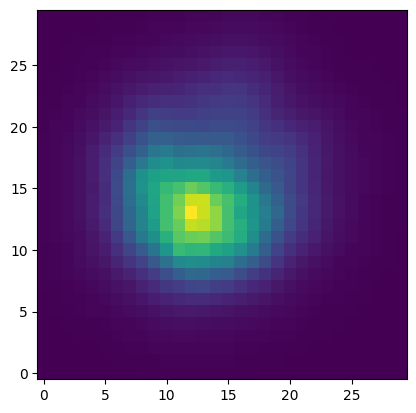

[787.10863808 555.33338685]
red


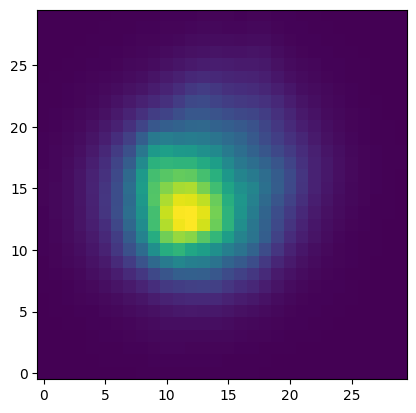

[786.69956753 549.57455444]


In [ ]:
## Estimate position with an initial position guess of the star with centroid
filtros['black']['pos_guess'] = [784,570]   ## initial guess (x,y) (CHANGE TO YOUR STAR POSITION!)
filtros['blue']['pos_guess'] = [785,557]
filtros['red']['pos_guess'] = [789,550]
filtros['green']['pos_guess'] = [789,556]
from photutils.centroids import centroid_com, centroid_2dg  #load centroid libraries
for k,v in filtros.items():
  #if k!='blue':
    filtros[k]['img'] = filtros[k]['image'][filtros[k]['pos_guess'][1]-15:filtros[k]['pos_guess'][1]+15,filtros[k]['pos_guess'][0]-15:filtros[k]['pos_guess'][0]+15]#select subportion of 60x60 image
    print(k)
    plt.imshow(filtros[k]['img'],origin='lower')
    plt.show()
    filtros[k]['position'] = centroid_com(filtros[k]['img'])+filtros[k]['pos_guess']-[15,15]
    print(filtros[k]['position'])
#blue

#filtros['blue']['img'] = filtros['blue']['image'][filtros['blue']['pos_guess'][1]-15:filtros['blue']['pos_guess'][1]+15,filtros['blue']['pos_guess'][0]-15:filtros['blue']['pos_guess'][0]+15]#select subportion of 60x60 image
#print('blue')
#plt.imshow(filtros['blue']['img'],origin='lower')
#plt.show()
#filtros['blue']['position'] = centroid_com(filtros[k]['img'])+filtros['blue']['pos_guess']-[15,15]
#print(filtros['blue']['position'])

Do aperture photometry

black
 id      xcenter           ycenter      ...  aperture_sum_21  aperture_sum_err_21
           pix               pix        ...                                      
--- ----------------- ----------------- ... ----------------- -------------------
  1 783.5857481370665 567.9365700613015 ... 8166615.441367906  2359.5216186257035
[1356.6165794  1663.73161559 1874.73553501 2015.79329552 2111.11383018
 2176.67612769 2222.7376113  2255.64616996 2279.27102263 2296.37817124
 2308.81299319 2318.0196516  2325.10009455 2330.75033304 2335.51626707
 2339.65199965 2343.36474679 2346.81269465 2350.10879722 2353.30581803
 2356.42666087 2359.52161863]
black
blue
 id      xcenter           ycenter      ...  aperture_sum_21  aperture_sum_err_21
           pix               pix        ...                                      
--- ----------------- ----------------- ... ----------------- -------------------
  1 788.6566911424071 554.9789474316296 ... 7088981.524749263   2351.065486182199
[ 986.0538587

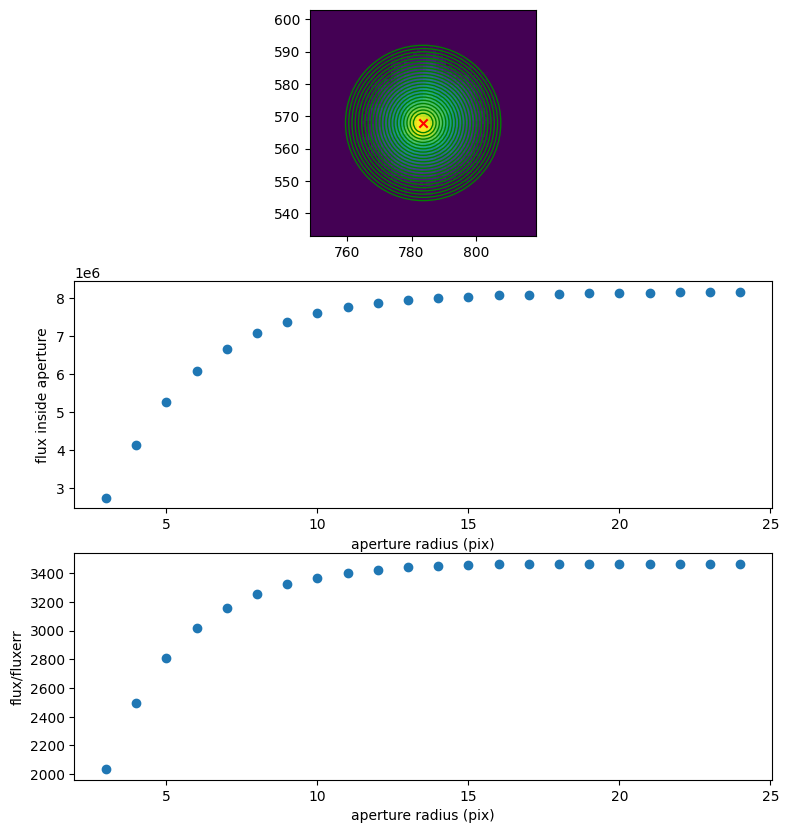

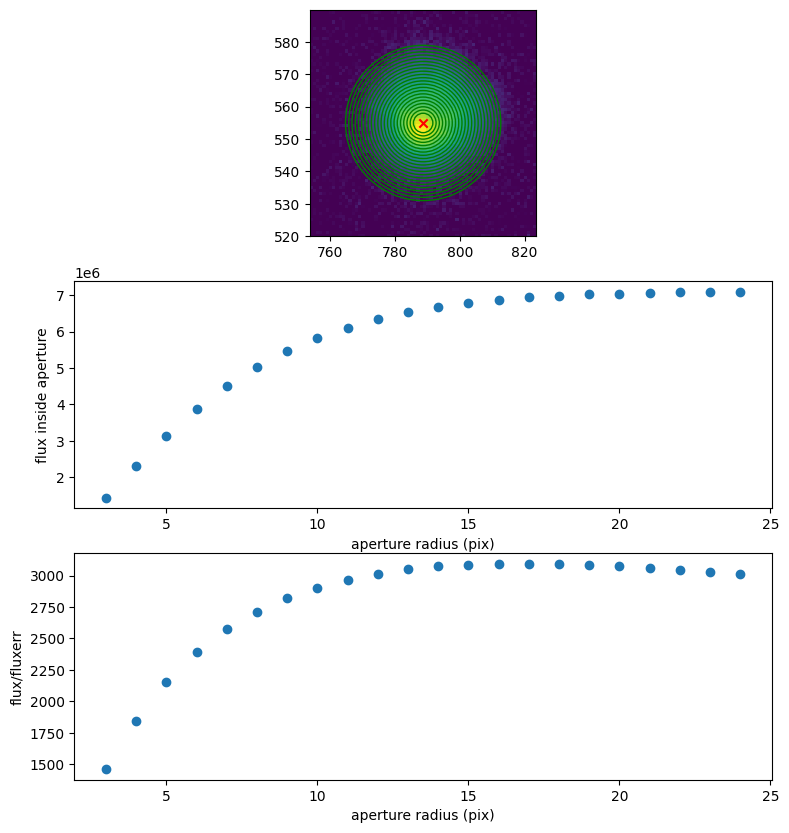

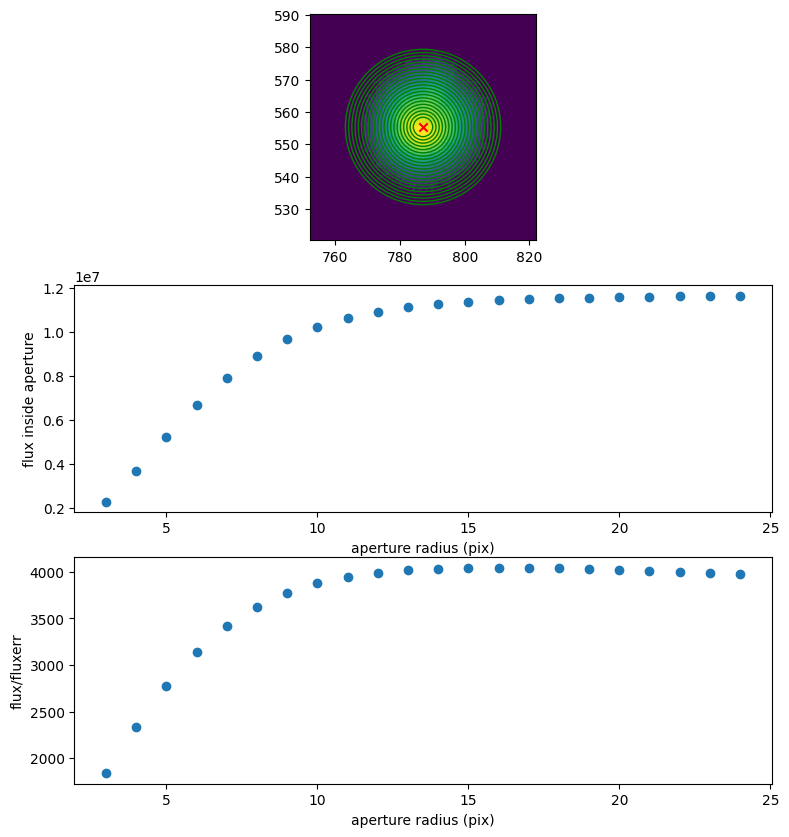

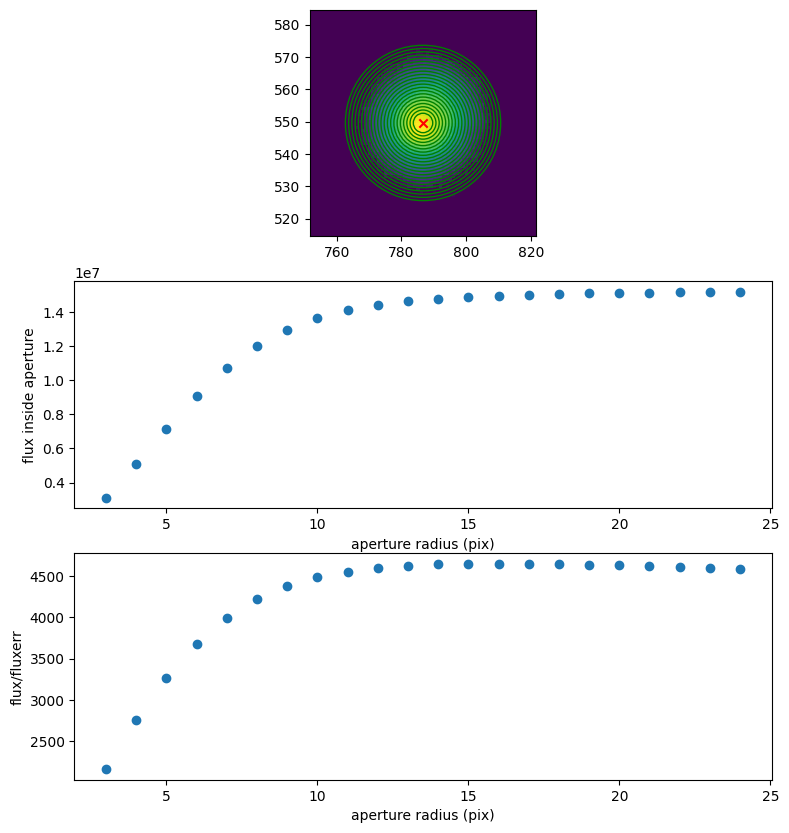

In [ ]:
## Get several apertures for one star position (you could have more positions)
from photutils.aperture import CircularAperture
from astropy.visualization import simple_norm

for k,v in filtros.items():
  print(k)
  radii = np.arange(3,25)  # radii (pix) of circular apertures
  filtros[k]['aperture'] = [CircularAperture(filtros[k]['position'], r=r) for r in radii] # define circular apertures

  ## Perform aperture photometry (sum of all pixels within aperture) SUBTRACTING first background found previously
  filtros[k]['phot_table'] = aperture_photometry(filtros[k]['image']-filtros[k]['bkg'].background, filtros[k]['aperture'],error=filtros[k]['erimage'])
  print(filtros[k]['phot_table'])  ## print table
  filtros[k]['y'] = np.asarray([filtros[k]['phot_table']['aperture_sum_'+str(i)] for i in np.arange(0,radii.size)],dtype=float)
  filtros[k]['ery'] = np.asarray([filtros[k]['phot_table']['aperture_sum_err_'+str(i)] for i in np.arange(0,radii.size)],dtype=float)
  filtros[k]['y']=np.reshape(filtros[k]['y'], (len(filtros[k]['y']),))
  filtros[k]['ery']=np.reshape(filtros[k]['ery'], (len(filtros[k]['ery']),))
  print(filtros[k]['ery'])

  ## Plot both: curve growth and image with apertures
  print(k)
  fig,ax = plt.subplots(3,figsize=(9,10))
  filtros[k]['norm'] = simple_norm(filtros[k]['img'],'log',percent=99.)
  ax[0].imshow(filtros[k]['image'],norm=filtros[k]['norm'],cmap='viridis', aspect=1, interpolation='nearest')
  ax[0].scatter(filtros[k]['position'][0],filtros[k]['position'][1],color='red',marker='x')
  for r in radii:
    circle = plt.Circle(filtros[k]['position'],r,color='green',fill=False)
    ax[0].add_artist(circle)
  ax[0].set_xlim([filtros[k]['position'][0]-35,filtros[k]['position'][0]+35])
  ax[0].set_ylim([filtros[k]['position'][1]-35,filtros[k]['position'][1]+35])
  # plot curve of growth
  ax[1].errorbar(radii,filtros[k]['y'],yerr=filtros[k]['ery'],fmt='o')
  ax[1].set_xlabel('aperture radius (pix)')
  ax[1].set_ylabel('flux inside aperture')
  # plot flux/fluxerr (S/N)
  ax[2].errorbar(radii,filtros[k]['y']/filtros[k]['ery'],fmt='o')
  ax[2].set_xlabel('aperture radius (pix)')
  ax[2].set_ylabel('flux/fluxerr')


In [ ]:
import math
z=5.4*math.pi/180
print(print(math.cos(z)))
for k,v in filtros.items():
## Final flux and error at a given radius. All stars in the same image should have SAME radius
  radius = 22 # (CHANGE TO YOUR RADIUS!) -choose radius (here large radius since curve of growth is nice -it has an asymptotic value- but if not take a smaller radius where S/N is high, i.e ~16 in this example)
  filtros[k]['flux'] = filtros[k]['y'][np.round(radii) == np.round(radius)]
  filtros[k]['error'] = filtros[k]['ery'][np.round(radii) == np.round(radius)]
  print("    Star flux (counts): %f +/- %f" %(filtros[k]['flux'],filtros[k]['error']))


0.99556196460308
None
    Star flux (counts): 8154221.082468 +/- 2353.305818
    Star flux (counts): 7071624.213782 +/- 2321.161272
    Star flux (counts): 11601193.787960 +/- 2899.721475
    Star flux (counts): 15165328.906305 +/- 3288.441014


<ipython-input-21-ffc289245bc9>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("    Star flux (counts): %f +/- %f" %(filtros[k]['flux'],filtros[k]['error']))


**Associar contagens com o fluxo real**

Black


In [ ]:
mag=3.45
fluxo=10**(-mag/2.5)
#tempos de exposição da sheliak e da M57
ts=0.1
tm=320
Kn=fluxo/filtros['black']['flux']*ts/tm
print(f'K Black é: {Kn}')

K Black é: [1.59759812e-12]


Blue


In [ ]:
k=0.25
F0=632e-11    # fluxo de vega em erg cm-2 s-1 A-1
mag=3.42 + k/math.cos(z)
fluxo=F0*10**(-mag/2.5)
#tempos de exposição da sheliak e da M57
ts=1.1
tm=570
Kb=fluxo/filtros['blue']['flux']*ts/tm
print(f'K Blue é: {Kb}')

K Blue é: [5.86502613e-20]


Green


In [ ]:
k=0.15
F0=363.1e-11
mag=3.42 + k/math.cos(z)
fluxo=F0*10**(-mag/2.5)
#tempos de exposição da sheliak e da M57
ts=1.1
tm=630
Kg=fluxo/filtros['green']['flux']*ts/tm
print(f'K Green é: {Kg}')

K Green é: [2.03848835e-20]


Red



In [ ]:
k=0.09
F0=217.7e-11
mag=3.31 + k/math.cos(z)
fluxo=F0*10**(-mag/2.5)
#tempos de exposição da sheliak e da M57
ts=1.1
tm=270
Kr=fluxo/filtros['red']['flux']*ts/tm
print(f'K Red é: {Kr}')

K Red é: [2.55196689e-20]


Valores de K

In [ ]:
#Constante de calibração
print(f'C Red é: {Kr} (erg cm-2 s-1 A-1) por contagem')
print(f'C Green é: {Kg} (erg cm-2 s-1 A-1) por contagem')
print(f'C Blue é: {Kb} (erg cm-2 s-1 A-1) por contagem')
print(f'C Black é: {Kn} (erg cm-2 s-1 A-1) por contagem')

C Red é: [2.55196689e-20] (erg cm-2 s-1 A-1) por contagem
C Green é: [2.03848835e-20] (erg cm-2 s-1 A-1) por contagem
C Blue é: [5.86502613e-20] (erg cm-2 s-1 A-1) por contagem
C Black é: [1.59759812e-12] (erg cm-2 s-1 A-1) por contagem
